In [1]:
import pickle
import torch
import os
import matplotlib.pyplot as plt
from src.utils.paths import get_path
from src.utils.utils import CPU_Unpickler
from pathlib import Path
from src.dataset.dataset import EventDataset
import numpy as np

filename = get_path("/work/gkrzmanc/jetclustering/results/train/Test_LGATr_all_datasets_2025_01_08_19_27_54/eval_0.pkl", "results")
# for rinv=0.7, see /work/gkrzmanc/jetclustering/results/train/Test_betaPt_BC_rinv07_2025_01_03_15_38_58

result = CPU_Unpickler(open(filename, "rb")).load()
dataset = EventDataset.from_directory(result["filename"], mmap=True)


/work/gkrzmanc/jetclustering/code/src/utils/utils.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_location='cpu')


In [2]:
result.keys()

dict_keys(['event_idx', 'GT_cluster', 'pred', 'eta', 'phi', 'pt', 'mass', 'AK8_cluster', 'radius_cluster_GenJets', 'radius_cluster_FatJets', 'filename'])

In [3]:
result["filename"]

'/work/gkrzmanc/jetclustering/preprocessed_data/scouting_PFNano_signals2/SVJ_hadronic_std/s-channel_mMed-700_mDark-20_rinv-0.5'

In [11]:
# plotly 3d plot of result["pred"], colored by result["GT_cluster"]
from src.plotting.plot_coordinates import plot_coordinates
filt = result["event_idx"] == 3
plot_coordinates(torch.tensor(result["pred"][filt, :3]), torch.tensor(result["pt"][filt]), torch.tensor(result["GT_cluster"][filt])).show()


[('X', (268, 1)), ('Y', (268, 1)), ('Z', (268, 1)), ('tIdx', (268, 1)), ('pt', (268, 1))]


/tmp/ipykernel_25434/1782011407.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [12]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=20, cluster_selection_epsilon=0.1)
cluster_labels = clusterer.fit_predict(result["pred"][filt, :4])
plot_coordinates(result["pred"][filt, :3], result["pt"][filt], torch.tensor(cluster_labels)).show()


[('X', (268, 1)), ('Y', (268, 1)), ('Z', (268, 1)), ('tIdx', (268, 1)), ('pt', (268, 1))]


/work/gkrzmanc/1gatr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/work/gkrzmanc/1gatr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [41]:
from tqdm import tqdm
def get_clustering_labels(coords, batch_idx):
    labels = []
    for i in tqdm(np.unique(batch_idx)):
        filt = batch_idx == i
        clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=20, cluster_selection_epsilon=0.1)
        cluster_labels = clusterer.fit_predict(coords[filt])
        labels.append(cluster_labels)
    return np.concatenate(labels)

In [42]:
#labels = get_clustering_labels(result["pred"][:, :3], result["event_idx"])
labels =

  0%|          | 0/18496 [00:00<?, ?it/s]/work/gkrzmanc/1gatr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/work/gkrzmanc/1gatr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/work/gkrzmanc/1gatr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/work/gkrzmanc/1gatr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/work/gkrzmanc/1gatr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/work/gkr

KeyboardInterrupt: 

In [6]:
from src.jetfinder.basicjetfinder import basicjetfinder
from src.jetfinder.basicjetfinder_types import PseudoJet

In [43]:
event = dataset[1]

tensor(18495.)

In [8]:
def get_pseudojets(event):
    pseudojets = []
    for i in range(len(event.pfcands)):
        pseudojets.append(PseudoJet(event.pfcands.pxyz[i, 0].item(), event.pfcands.pxyz[i, 1].item(), event.pfcands.pxyz[i, 2].item(), event.pfcands.E[i].item()))
    return pseudojets
import fastjet
def get_pseudojets_fastjet(event):
    pseudojets = []
    for i in range(len(event.pfcands)):
        pseudojets.append(fastjet.PseudoJet(event.pfcands.pxyz[i, 0].item(), event.pfcands.pxyz[i, 1].item(), event.pfcands.pxyz[i, 2].item(), event.pfcands.E[i].item()))
    return pseudojets

In [9]:
pj = get_pseudojets(event)
init_jets, history = basicjetfinder(pj, return_raw=True)

In [10]:
pj[0].phi, pj[0].rap

(5.176739997422374, -1.1044922730459195)

In [11]:
event.pfcands.phi[0].item(), event.pfcands.eta[0].item()

(-1.1064453125, -1.1044921875)

In [12]:
history.parent1[-1], history.parent2[-1]
history.jetp_index[305]

305

In [13]:
jets = basicjetfinder(pj, return_raw=0, ptmin=100)

12


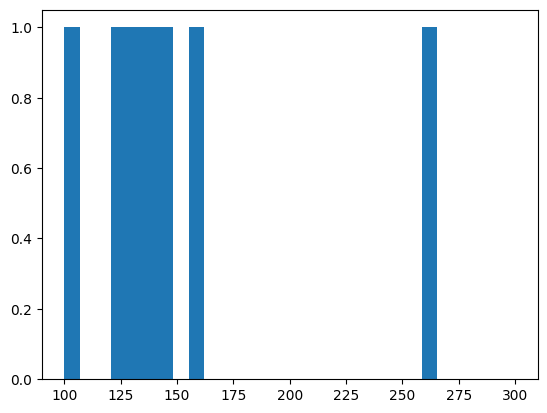

In [15]:
fig, ax = plt.subplots()
print(len(jets))
import numpy as np
pts = [jet.pt for jet in jets]
ax.hist(pts, bins=np.linspace(100, 300, 30))
fig.show()

In [16]:
pts

[106.4914540483752,
 126.82878103484677,
 128.75701244217592,
 139.36815083799416,
 141.45818096650805,
 157.3921266403816,
 263.460560295077,
 510.77385760617676,
 1265.8454239380796,
 3240.9516711140454,
 9355.60575745164,
 12409.915133671686]

In [14]:
history.parent1[-1], history.parent2[-1]


(305, -1)

In [15]:
history.parent1

array([ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -

In [16]:
history.parent2

array([ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -

In [34]:
import fastjet
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.8)
array = get_pseudojets_fastjet(event)

cluster = fastjet.ClusterSequence(array, jetdef)
inc_jets = cluster.inclusive_jets()

for elem in inc_jets:
    pt = elem.pt()
    if pt < 100:
        continue
    print("pt:", elem.pt(), "eta:", elem.rap())

pt: 132.20828148108546 eta: -0.0754104485813396
pt: 200.7486894820125 eta: -1.148074263928614
pt: 401.81239814256105 eta: -1.1010204529261447


In [37]:
event.fatjets.pt.tolist(), event.fatjets.eta.tolist()

([401.8123779296875, 200.74868774414062, 126.27354431152344],
 [-1.1161537170410156, -1.205527901649475, -0.07039077579975128])

In [45]:
result["filename"]

'/work/gkrzmanc/jetclustering/preprocessed_data/scouting_PFNano_signals2/SVJ_hadronic_std/s-channel_mMed-900_mDark-20_rinv-0.3'

In [5]:
model_clusters_file ="/work/gkrzmanc/jetclustering/results/train/Test_betaPt_BC_2025_01_03_15_07_14/HDBSCAN_10_20.pkl"
model_output_file = "/work/gkrzmanc/jetclustering/results/train/Test_betaPt_BC_2025_01_03_15_07_14/eval_0.pkl"


In [6]:
ds = EventDataset.from_directory("/work/gkrzmanc/jetclustering/preprocessed_data/scouting_PFNano_signals2/SVJ_hadronic_std/s-channel_mMed-900_mDark-20_rinv-0.3",
             model_clusters_file=model_clusters_file, model_output_file=model_output_file)

/work/gkrzmanc/jetclustering/code/src/utils/utils.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_location='cpu')


In [7]:
labels = CPU_Unpickler(open("/work/gkrzmanc/jetclustering/results/train/Test_betaPt_BC_2025_01_03_15_07_14/HDBSCAN_10_20.pkl", "rb")).load()
labels

array([ 0,  2,  2, ...,  1,  0, -1])

tensor([427.9641, 391.8387])


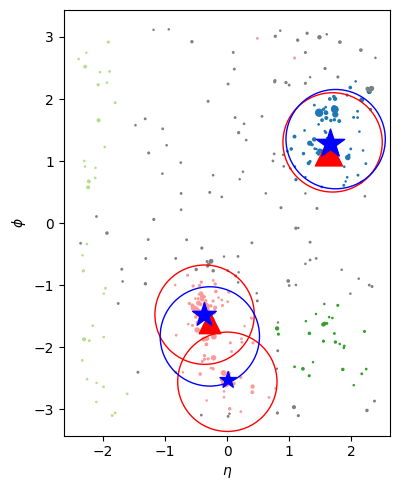

In [8]:
from src.plotting.plot_event import plot_event
clist = ['#1f78b4', '#b3df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbe6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']
colors = {
    -1: "gray",
    0: clist[0],
    1: clist[1],
    2: clist[2],
    3: clist[3],
    4: clist[4],
    5: clist[5],
    6: clist[6],
    7: clist[7],
}

idx = 4
c = [colors[i] for i in labels[result["event_idx"] == idx]]

plot_event(ds[idx], colors=c).show()

print(ds[idx].model_jets.pt)

In [4]:
pt_model_jet = []
for i in range(200):
    pt_model_jet += ds[i].model_jets.pt.tolist()

NameError: name 'ds' is not defined

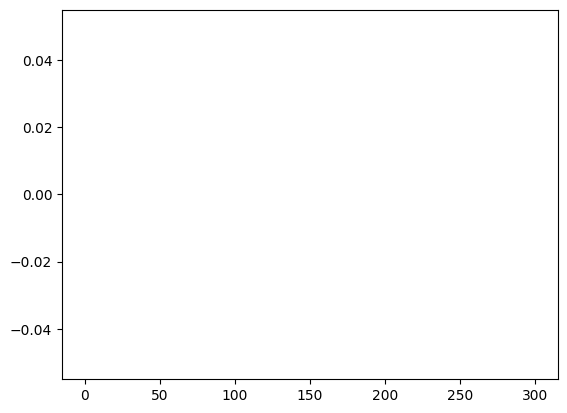

In [6]:
fig, ax = plt.subplots()
ax.hist(pt_model_jet, bins=np.linspace(0, 300, 30))
fig.show()